---
# Cairo University Faculty of Engineering
## Deep Learning
## Assignment 5_2

---

Please write your full name here
- **Name** : "Mohamed Nasser Hussein"

## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits.
Within this notebook you will find instructions in each section for how to complete the assignment.

Pay close attention to the instructions. Feel free to add extra cells into the notebook as required.

### Let's get started!

We'll start by running some imports, and loading the dataset. You are free to make further imports throughout the notebook as you wish.

In [1]:
import tensorflow as tf
from scipy.io import loadmat

For this assignmnet, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`.

- If using Colab: You should store these files in Drive.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
### Using Colab only
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import requests
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the destination folder in your Google Drive
destination_folder = '/content/drive/MyDrive/datasets/svhn'

# Create the destination folder if it doesn't exist
!mkdir -p "{destination_folder}"

# Define the URL of the SVHN dataset in MATLAB format
url = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'

# Download the dataset
response = requests.get(url)

# Save the downloaded file to Google Drive
with open(f'{destination_folder}/test_32x32.mat', 'wb') as f:
    f.write(response.content)


Mounted at /content/drive


In [34]:
# Load the dataset from your Drive folder

train = loadmat('/content/drive/MyDrive/datasets/svhn/train_32x32.mat')
test = loadmat('/content/drive/MyDrive/datasets/svhn/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure. Make sure that the images are displayed in grayscale!!

In [35]:
import matplotlib.pyplot as plt

# Extract the training and testing data
train_data = train['X']
train_labels = train['y']

test_data = test['X']
test_labels = test['y']
train_data=train_data.transpose((3,0,1,2))
test_data=test_data.transpose((3,0,1,2))


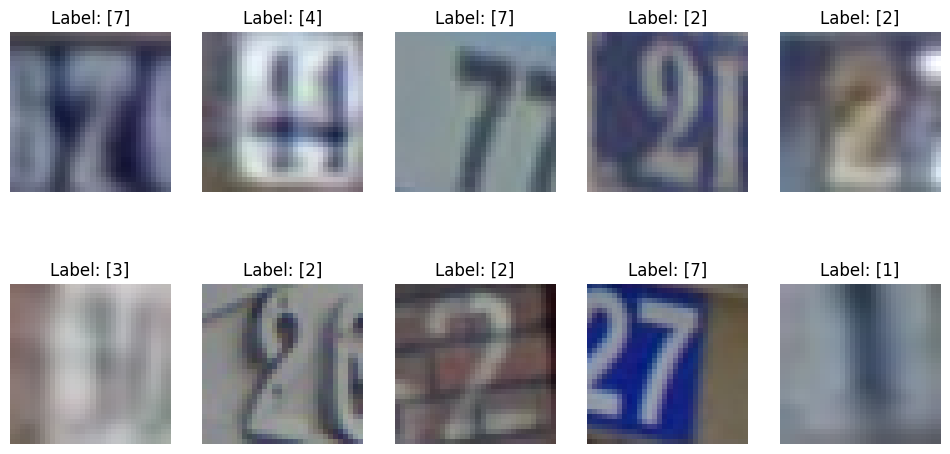

In [36]:
import random
def display_images(images, labels, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
random_indices = random.sample(range(len(train_data)), 10)

# Extract the sample images and labels
sample_images = train_data[random_indices]
sample_labels = train_labels[random_indices]

# Display the sample images with labels
display_images(sample_images, sample_labels, 10)


In [37]:
import numpy as np

def rgb_to_grayscale(images):
    return np.mean(images, axis=-1, keepdims=True)

In [38]:
train_data_gray = rgb_to_grayscale(train_data)
test_data_gray = rgb_to_grayscale(test_data)

In [39]:
print(train_data_gray.shape)

(73257, 32, 32, 1)


In [40]:
train_labels=train_labels-1
test_labels=test_labels-1

In [41]:
tf.reshape(train_labels,(train_labels.shape[0]))

<tf.Tensor: shape=(73257,), dtype=uint8, numpy=array([0, 8, 1, ..., 0, 5, 8], dtype=uint8)>

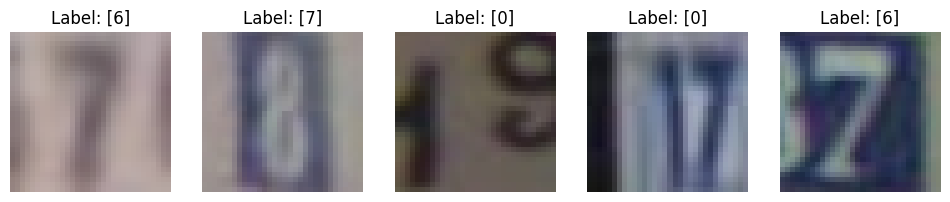

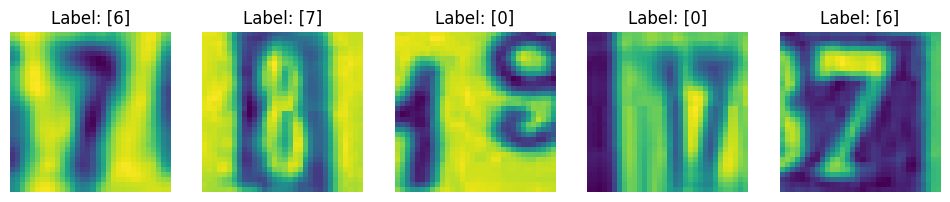

In [42]:
random_indices = random.sample(range(len(train_data)), 5)

# Original images
display_images(train_data[random_indices], train_labels[random_indices], 5)

# Grayscale images
display_images(train_data_gray[random_indices], train_labels[random_indices], 5)

In [43]:
from tensorflow.keras.utils import to_categorical
train_data_gray = tf.convert_to_tensor(train_data_gray, dtype=tf.float32)
test_data_gray = tf.convert_to_tensor(test_data_gray, dtype=tf.float32)

train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
train_labels=tf.reshape(train_labels,(train_labels.shape[0]))

test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)
test_labels=tf.reshape(test_labels,(test_labels.shape[0]))




# Convert labels to one-hot vectors



In [44]:
train_data_gray_normalized = tf.image.per_image_standardization(train_data_gray)
test_data_gray_normalized = tf.image.per_image_standardization(train_data_gray)


## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output.
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least one **callback** during training, like a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization

model_mlp = Sequential()

model_mlp.add(Flatten(input_shape=(32, 32, 1)))
model_mlp.add(BatchNormalization())  # Add BatchNormalization layer
model_mlp.add(Dense(128, activation='relu'))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dense(10, activation='softmax'))


In [127]:
model_mlp.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 1024)              0         
                                                                 
 batch_normalization_34 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_45 (Dense)            (None, 128)               131200    
                                                                 
 dense_46 (Dense)            (None, 64)                8256      
                                                                 
 dense_47 (Dense)            (None, 10)                650       
                                                                 
Total params: 144202 (563.29 KB)
Trainable params: 142154 (555.29 KB)
Non-trainable params: 2048 (8.00 KB)
____________

In [128]:

# Compile the model
model_mlp.compile(optimizer='adam', # Use the Adam optimizer
              loss='sparse_categorical_crossentropy', # Use the categorical cross entropy loss
              metrics=['accuracy']) #

In [129]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model.h5', # Save the model as model.h5
                             save_best_only=True, # Save only the best model
                             monitor='val_loss', # Monitor the validation loss
                             mode='min') #

In [130]:
history=model_mlp.fit(train_data_gray, train_labels, epochs=10, batch_size=64, validation_split=0.2,callbacks=[checkpoint])

Epoch 1/10
916/916 [==============================] - 6s 5ms/step - loss: 1.3224 - accuracy: 0.5775 - val_loss: 0.9965 - val_accuracy: 0.6910
Epoch 2/10
916/916 [==============================] - 11s 12ms/step - loss: 0.9221 - accuracy: 0.7144 - val_loss: 0.8142 - val_accuracy: 0.7556
Epoch 3/10
916/916 [==============================] - 8s 8ms/step - loss: 0.7971 - accuracy: 0.7568 - val_loss: 0.7855 - val_accuracy: 0.7637
Epoch 4/10
916/916 [==============================] - 9s 9ms/step - loss: 0.7270 - accuracy: 0.7780 - val_loss: 0.7093 - val_accuracy: 0.7896
Epoch 5/10
916/916 [==============================] - 5s 5ms/step - loss: 0.6839 - accuracy: 0.7926 - val_loss: 0.7041 - val_accuracy: 0.7938
Epoch 6/10
916/916 [==============================] - 6s 7ms/step - loss: 0.6471 - accuracy: 0.8025 - val_loss: 0.6658 - val_accuracy: 0.8044
Epoch 7/10
916/916 [==============================] - 8s 9ms/step - loss: 0.6162 - accuracy: 0.8112 - val_loss: 0.6468 - val_accuracy: 0.8127
Epoc

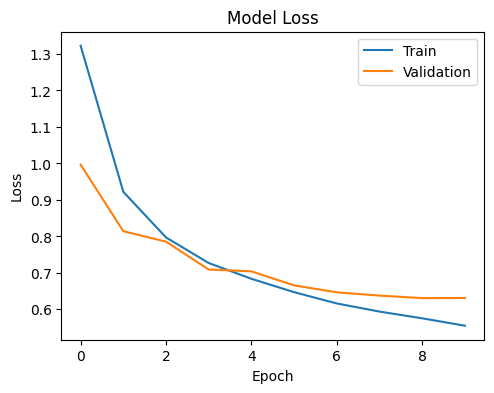

In [131]:
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

In [132]:
test_loss, test_accuracy = model_mlp.evaluate(test_data_gray, test_labels)

# Display the test metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

814/814 [==============================] - 2s 3ms/step - loss: 0.7554 - accuracy: 0.7930
Test Loss: 0.7554
Test Accuracy: 0.7930


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output.
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model **must** use fewer trainable parameters than your MLP model.
* Compile and train the model (recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least one callback during training, like a ModelCheckpoint callback.
* **You should aim to beat the MLP model performance with fewer parameters!**
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [229]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout

input_shape = (32, 32, 1)

model_cnn = Sequential()

model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))

model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3), activation='relu'))

model_cnn.add(BatchNormalization())

model_cnn.add(MaxPool2D((2, 2)))

model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())

model_cnn.add(Dense(64, activation='relu'))

model_cnn.add(Dropout(0.5))

model_cnn.add(Dense(10, activation='softmax'))


In [230]:
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [231]:
model_cnn.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 batch_normalization_37 (Ba  (None, 30, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_38 (Ba  (None, 28, 28, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                     

In [232]:
checkpoint2 = ModelCheckpoint('model.h6', # Save the model as model.h5
                             save_best_only=True, # Save only the best model
                             monitor='val_loss', # Monitor the validation loss
                             mode='min') #

In [233]:
history2=model_cnn.fit(train_data_gray, train_labels, epochs=10, batch_size=64, validation_split=0.2,callbacks=[checkpoint2])


Epoch 1/10
916/916 [==============================] - 13s 13ms/step - loss: 1.5589 - accuracy: 0.4885 - val_loss: 0.7935 - val_accuracy: 0.7689
Epoch 2/10
916/916 [==============================] - 10s 11ms/step - loss: 0.9184 - accuracy: 0.7075 - val_loss: 0.5963 - val_accuracy: 0.8238
Epoch 3/10
916/916 [==============================] - 10s 11ms/step - loss: 0.7318 - accuracy: 0.7667 - val_loss: 0.5250 - val_accuracy: 0.8452
Epoch 4/10
916/916 [==============================] - 8s 9ms/step - loss: 0.6474 - accuracy: 0.7954 - val_loss: 0.5713 - val_accuracy: 0.8356
Epoch 5/10
916/916 [==============================] - 10s 10ms/step - loss: 0.5936 - accuracy: 0.8114 - val_loss: 0.4751 - val_accuracy: 0.8625
Epoch 6/10
916/916 [==============================] - 10s 11ms/step - loss: 0.5573 - accuracy: 0.8242 - val_loss: 0.4548 - val_accuracy: 0.8643
Epoch 7/10
916/916 [==============================] - 9s 10ms/step - loss: 0.5245 - accuracy: 0.8339 - val_loss: 0.4940 - val_accuracy: 0.

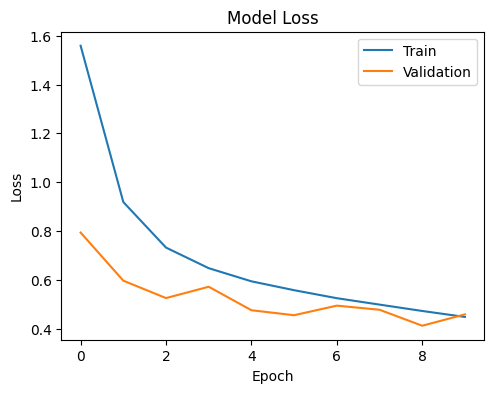

In [234]:
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

In [235]:
test_loss, test_accuracy = model_cnn.evaluate(test_data_gray, test_labels)

# Display the test metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

814/814 [==============================] - 2s 3ms/step - loss: 0.5130 - accuracy: 0.8498
Test Loss: 0.5130
Test Accuracy: 0.8498


## 4. Get model predictions
* Load the **best weights** for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [236]:
from tensorflow.keras.models import load_model
import random

# Load the best weights for MLP model
mlp_model = load_model('model.h5')

# Load the best weights for CNN model
cnn_model = load_model('model.h6')

In [237]:
images = tf.random.shuffle(test_data_gray)
images=images[:5]

In [238]:
predictions_mlp = mlp_model.predict(images)
predictions_cnn = cnn_model.predict(images)

1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 77ms/step


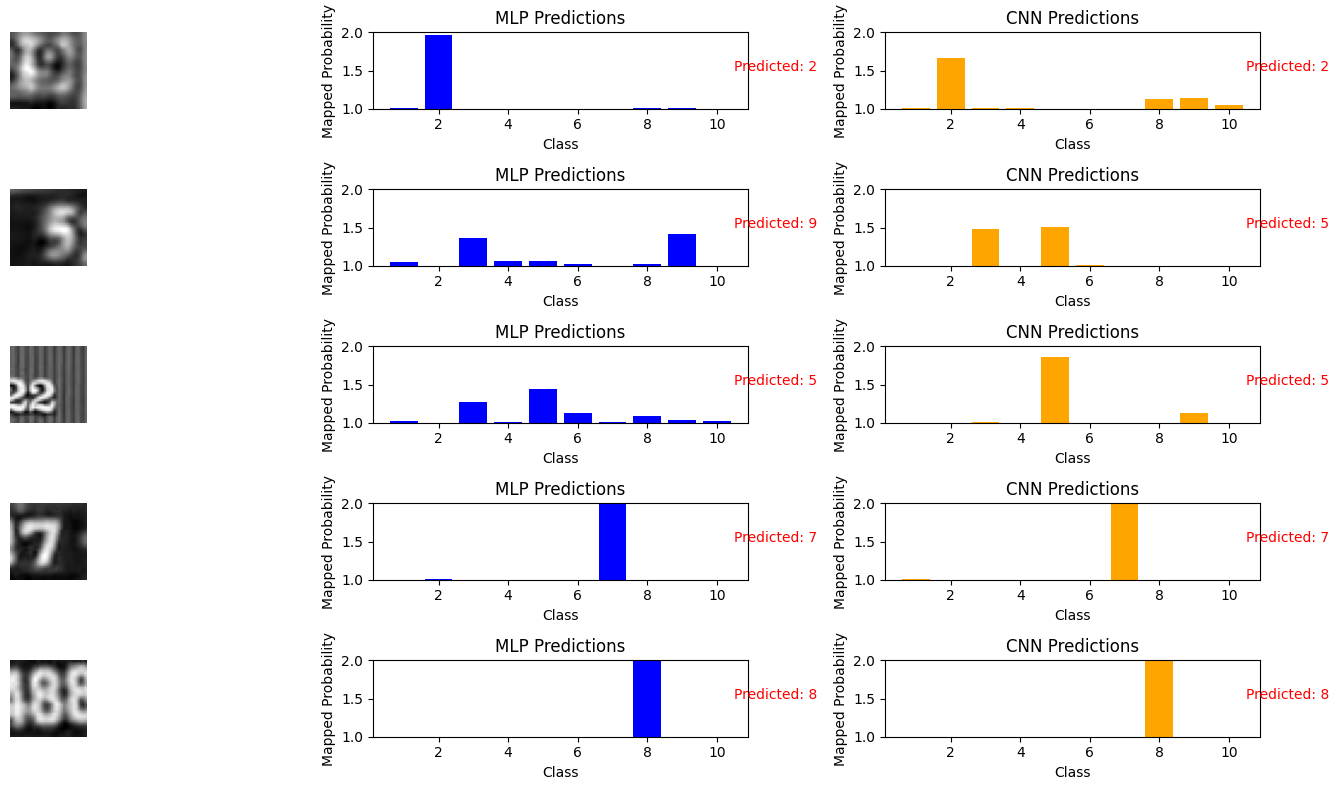

In [240]:
plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(images[i], cmap='gray')  # Squeeze removes the channel dimension
    plt.axis('off')

    # Plot MLP predictive distribution
    plt.subplot(5, 3, i * 3 + 2)
    plt.bar(range(1, 11), predictions_mlp[i] + 1, color='blue')  # Shift and map predictions to [1, 10]
    plt.title('MLP Predictions')
    plt.xlabel('Class')
    plt.ylabel('Mapped Probability')
    plt.ylim([1, 2])

    # Identify the predicted class with the maximum probability for MLP
    predicted_class_mlp = np.argmax(predictions_mlp[i]) + 1
    plt.text(10.5, 1.5, f'Predicted: {predicted_class_mlp}', fontsize=10, color='red')

    # Plot CNN predictive distribution
    plt.subplot(5, 3, i * 3 + 3)
    plt.bar(range(1, 11), predictions_cnn[i] + 1, color='orange')  # Shift and map predictions to [1, 10]
    plt.title('CNN Predictions')
    plt.xlabel('Class')
    plt.ylabel('Mapped Probability')
    plt.ylim([1, 2])

    # Identify the predicted class with the maximum probability for CNN
    predicted_class_cnn = np.argmax(predictions_cnn[i]) + 1
    plt.text(10.5, 1.5, f'Predicted: {predicted_class_cnn}', fontsize=10, color='red')

plt.tight_layout()
plt.show()